In [21]:
import torch
import numpy as np

from ACNet_pytorch import ACNet
from FireFightingEnv import FFEnv


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [22]:
# Initialize environment
agent_num = 3
env = FFEnv(agent_num=agent_num)

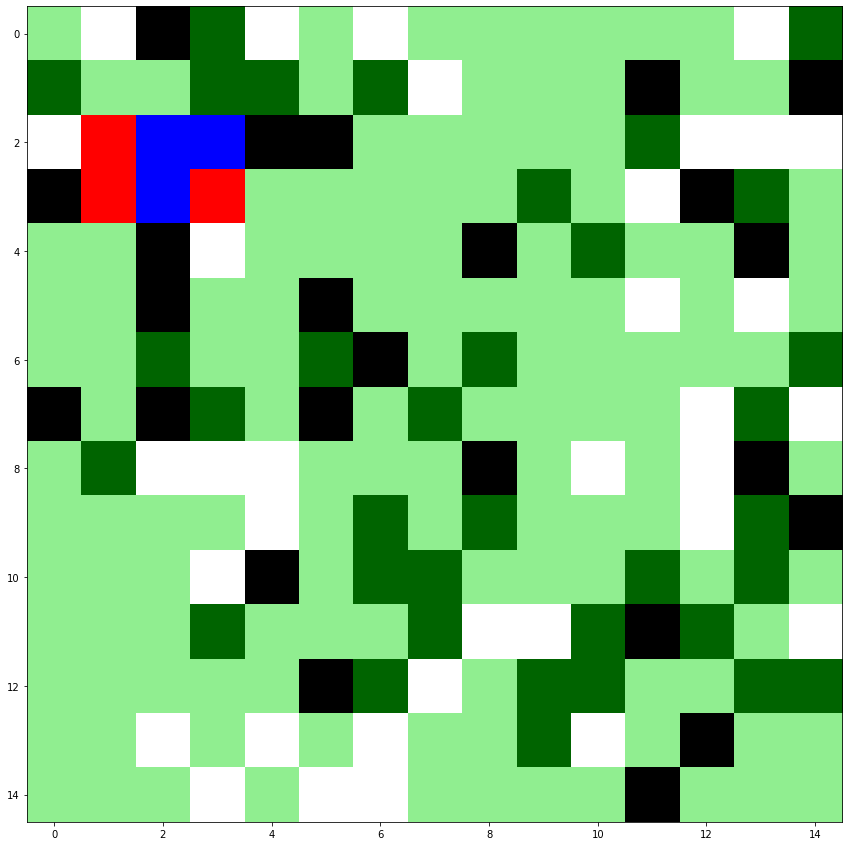

In [23]:
env.mapEnv.plotAll()

In [24]:
obs = np.array(env.observe_space)

# obstacle map of agent[0]
print(obs[0, 0], "\n")
# fire map of agent[0]
print(obs[0, 1], "\n")
# agent map of agent[0]
print(obs[0, 2], "\n")
# flammable map of agent[0]
print(obs[0, 3], "\n")
# reserved water of agent[0]
print(obs[0, 4], "\n")


[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0.]] 

[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.4]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]] 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

/home/peter/anaconda3/envs/course_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [25]:
# load data
inputs_raw = np.array(obs[:, :4])
inputs = []
for map in inputs_raw:
    reshaped_map = [np.array(arr) for arr in map]
    inputs.append(reshaped_map)
inputs = np.array(inputs)
print(inputs.shape)

water_res = np.array(obs[:, 4]).reshape(-1,1)
print(water_res.shape)

(3, 4, 11, 11)
(3, 1)


In [26]:
# action size: 4 direction movements, stop, 4 direction spraying with short/long range, and go back to water supply station.
a_size = 4 + 1 + 4 + 1
trainer = torch.optim.SGD
TRAINING = True
GRID_SIZE = 11
# RNN_SIZE = 128
learning_rate=1e-4
agent_num = 3

# __init__(self, scope, a, trainer, TRAINING, GRID_SIZE)
net = ACNet(a_size, agent_num, trainer, learning_rate, TRAINING, GRID_SIZE)

QAQ! The network is working!


/home/peter/anaconda3/envs/course_env/lib/python3.6/site-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [27]:
inputs_torch = torch.from_numpy(inputs)
print(inputs_torch.shape)
water_res_torch = torch.from_numpy(water_res.astype(np.int64))
print(water_res_torch.shape)


torch.Size([3, 4, 11, 11])
torch.Size([3, 1])


In [28]:
state = env.reset()
episode_rollout = []
iteration = 10

actions, action_array = [],[]
for i in range(3):
    actions.append([[], []])
    action_array.append(0)

for t in range(iteration):
    # 2 parameter to describe 1 action
    # Direction:[0, 1, 2, 3, 4], moving or spraying:[0, 1]
    for i, a in enumerate(actions):
        a[0] = np.random.choice([0, 1, 2, 3, 4])
        a[1] = np.random.choice([0, 1])

        # encode action in action space
        action_array[i] = a[0] * 2 + a[1]
    
    s1, rewards, done = env.step(actions)

    state = np.array(state)
    maps_raw = np.array(state[:, :4])
    maps = []
    for map in maps_raw:
        reshaped_map = [np.array(arr) for arr in map]
        maps.append(reshaped_map)
    maps = np.array(maps)
    # maps = maps_raw
    
    water = np.array(state[:, 4]).reshape(-1,1)
    # water = np.array(state[:, 4])

    episode_rollout.append([maps, water, np.array(action_array), rewards])
    state = s1[:]

/home/peter/anaconda3/envs/course_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [29]:
# batch_size, channel, map_size[0], map_size[1]
inputs_torch    = torch.from_numpy(np.array([item[0] for item in episode_rollout]).reshape(iteration*agent_num, 4, 11, 11).astype(np.int64))
# batch_size, water_reserved
water_res_torch = torch.from_numpy(np.array([item[1] for item in episode_rollout]).reshape(iteration*agent_num, 1).astype(np.int64))
# batch_size
actions_torch   = torch.from_numpy(np.array([item[2] for item in episode_rollout]).reshape(iteration*agent_num).astype(np.int64))
# batch_size
rewards_torch   = torch.from_numpy(np.array([item[3] for item in episode_rollout]).reshape(iteration*agent_num).astype(np.float64))
print(inputs_torch.shape)
print(water_res_torch.shape)
print(actions_torch.shape)
print(rewards_torch.shape)


torch.Size([30, 4, 11, 11])
torch.Size([30, 1])
torch.Size([30])
torch.Size([30])
